### Titanic Machine Learning

This notebook aims to create a machine learning model that predicts which passengers survived from the titanic wreckship. The data comes from the Kaggle competition: https://www.kaggle.com/competitions/titanic/data

**Note:** The following description of the dataset can be found in the link above.

The data has been split into two groups:

* training set (`train.csv`)
* test set (`test.csv`)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include `gender_submission.csv`, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

The parameters of the training dataset are

1. `survival`: target value, if the passenger survived it takes the value 1 if not 0.
2. `pclass`: ticket class which can be 1 = 1st, 2 = 2nd or 3 = 3rd class
3. `sex`: sex of the passenger
4. `age`: age in years
5. `sibsp`: number of siblings/spouses aboard the Titanic
6. `parch`: number of children/parents aboard the Titanic
7. `ticke`t: ticket number
8. `fare`: passenger fare
9. `cabin`: cabin number
10. `embarked`: port of embarcation C = Cherbourg, Q = Queenstown, S = Southampton

Some aclarations about the parameters:

* pclass: A proxy for socio-economic status (SES)

    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)
    
* parch: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
# Import all the necessary tools for the classification problem

# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Import the data into a dataframe

df = pd.read_csv("data/train.csv")
df.shape

(891, 12)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


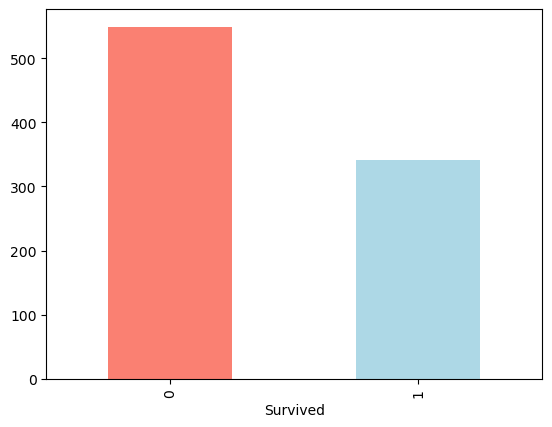

In [4]:
df.Survived.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Find out how many male/femal passengers were there in the Titanic

df.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [7]:
## First in order to use the data it will be necessary to impute it for that let's see the type of each column

df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
# save the preprocessed data 
df_tmp = df.copy()

In [9]:
df_tmp.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Name
Sex
Ticket


In [11]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):  # Broader check for any 'object' dtype
        df_tmp[label] = content.astype(str).astype("category").cat.as_ordered()

In [12]:
df_tmp.info(), df_tmp.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    category
 11  Embarked     891 non-null    category
dtypes: category(5), float64(2), int64(5)
memory usage: 122.1 KB


(None,
 PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin            0
 Embarked         0
 dtype: int64)

In [13]:
for label, content in df_tmp.items():
    if isinstance(content.dtype, pd.CategoricalDtype):
        if 'nan' in content.cat.categories:
            # Map 'nan' category to np.nan in the data
            df_tmp[label] = content.replace('nan', np.nan)

C:\Users\Asus\AppData\Local\Temp\ipykernel_1948\1702937008.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_tmp[label] = content.replace('nan', np.nan)


In [14]:
df_tmp.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
# The strategy is to fill the missing numerical values with the median

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column to know if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numerical data with the median
            df_tmp[label] = content.fillna(content.median())

In [16]:
df_tmp.isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
Age_is_missing      0
dtype: int64

In [17]:
# Turn categorical values into numbers

for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Binary column for the missing values
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1 to avoid the -1 category
        df_tmp[label] = pd.Categorical(content).codes + 1

In [18]:
df_tmp.isna().sum()

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                  0
Embarked               0
Age_is_missing         0
Name_is_missing        0
Sex_is_missing         0
Ticket_is_missing      0
Cabin_is_missing       0
Embarked_is_missing    0
dtype: int64

In [19]:
# Save the preprocessed data
df_tmp.to_csv("data/train_processed.csv")

In [20]:
# Check if the data is correctly loaded
df_processed = pd.read_csv("data/train_processed.csv")
df_processed.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Name_is_missing,Sex_is_missing,Ticket_is_missing,Cabin_is_missing,Embarked_is_missing
0,0,1,0,3,109,2,22.0,1,0,524,7.2500,0,3,False,False,False,False,True,False
1,1,2,1,1,191,1,38.0,1,0,597,71.2833,82,1,False,False,False,False,False,False
2,2,3,1,3,354,1,26.0,0,0,670,7.9250,0,3,False,False,False,False,True,False
3,3,4,1,1,273,1,35.0,1,0,50,53.1000,56,3,False,False,False,False,False,False
4,4,5,0,3,16,2,35.0,0,0,473,8.0500,0,3,False,False,False,False,True,False


In [21]:
# Compare Survived with Pclass
pd.crosstab(df_processed.Survived, df_processed.Pclass)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


That is a pretty good hint, the higher the class, the higher were also the chances to survive

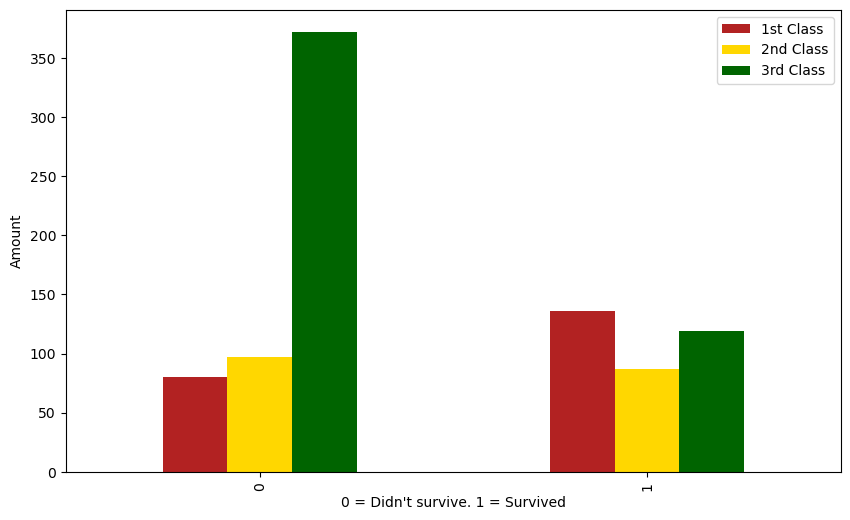

In [22]:
# Plot the crosstab
pd.crosstab(df_processed.Survived, df_processed.Pclass).plot(kind="bar",
                                                            figsize=(10,6),
                                                            color=["firebrick", "gold", "darkgreen"])
plt.xlabel("0 = Didn't survive. 1 = Survived")
plt.ylabel("Amount")
plt.legend(["1st Class", "2nd Class", "3rd Class"])

In [23]:
# Visualize the relation between Sex and Survived (1=female, 2=male)

pd.crosstab(df_processed.Survived, df_processed.Sex)

Sex,1,2
Survived,,
0,81,468
1,233,109


This is another good trend, more than 2/3 of the women survived, while only 25& of the men did

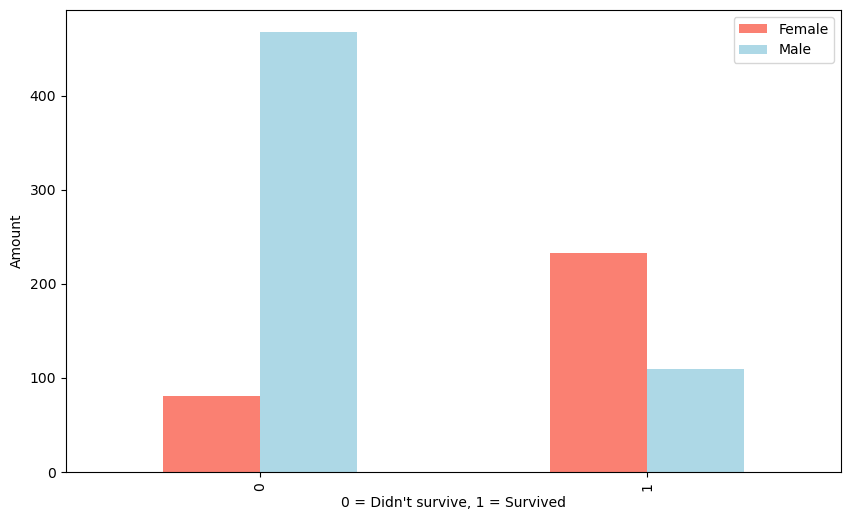

In [24]:
# Now we can look at it plotted

pd.crosstab(df_processed.Survived, df_processed.Sex).plot(kind="bar",
                                                          figsize=(10,6),
                                                          color=["salmon", "lightblue"])
plt.xlabel("0 = Didn't survive, 1 = Survived")
plt.ylabel("Amount")
plt.legend(["Female", "Male"]);

Now the last main parameter we will check is the Age

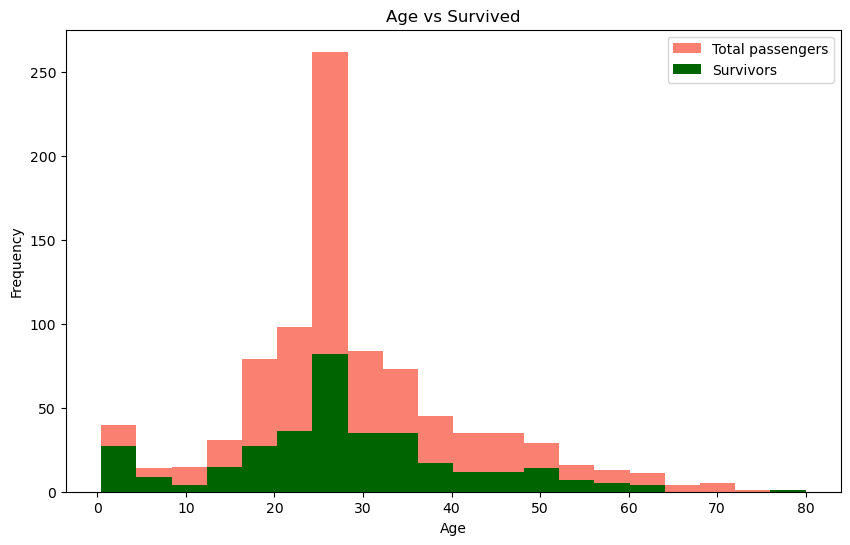

In [25]:
# Plot a histogramm with the age distribution

plt.figure(figsize=(10,6))
df_processed.Age.plot.hist(color="salmon", bins=20, label="Total passengers")
df_processed.Age[df_processed.Survived==1].plot.hist(color="darkgreen", bins=20, label="Survivors")
plt.title("Age vs Survived")
plt.xlabel("Age")
plt.legend()
plt.savefig("figures/age_survived_histogram.png")

Maybe this graph doesn't tell us a lot beside how distributed the ages were, so a better idea would be to show the survivance percentages

In [26]:
# Create a copy of only the necessary columns to avoid modifying the original DataFrame
temp_df = df_processed[['Age', 'Survived']].copy()

# Define bins for the age groups and labels for those bins
bins = np.linspace(0, 80, num=21)  # Creates 20 bins between 0 and 80
labels = [f'{int(left)}-{int(right)}' for left, right in zip(bins[:-1], bins[1:])]

# Bin the age data
temp_df['AgeGroup'] = pd.cut(temp_df['Age'], bins=bins, labels=labels, include_lowest=True)

# Group by the new AgeGroup and calculate survival rate
age_grouped = temp_df.groupby('AgeGroup')['Survived'].agg(['mean', 'count']).rename(columns={'mean': 'SurvivalRate', 'count': 'TotalCount'})

# Reset index to make AgeGroup a column
age_grouped.reset_index(inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_1948\3280932351.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_grouped = temp_df.groupby('AgeGroup')['Survived'].agg(['mean', 'count']).rename(columns={'mean': 'SurvivalRate', 'count': 'TotalCount'})


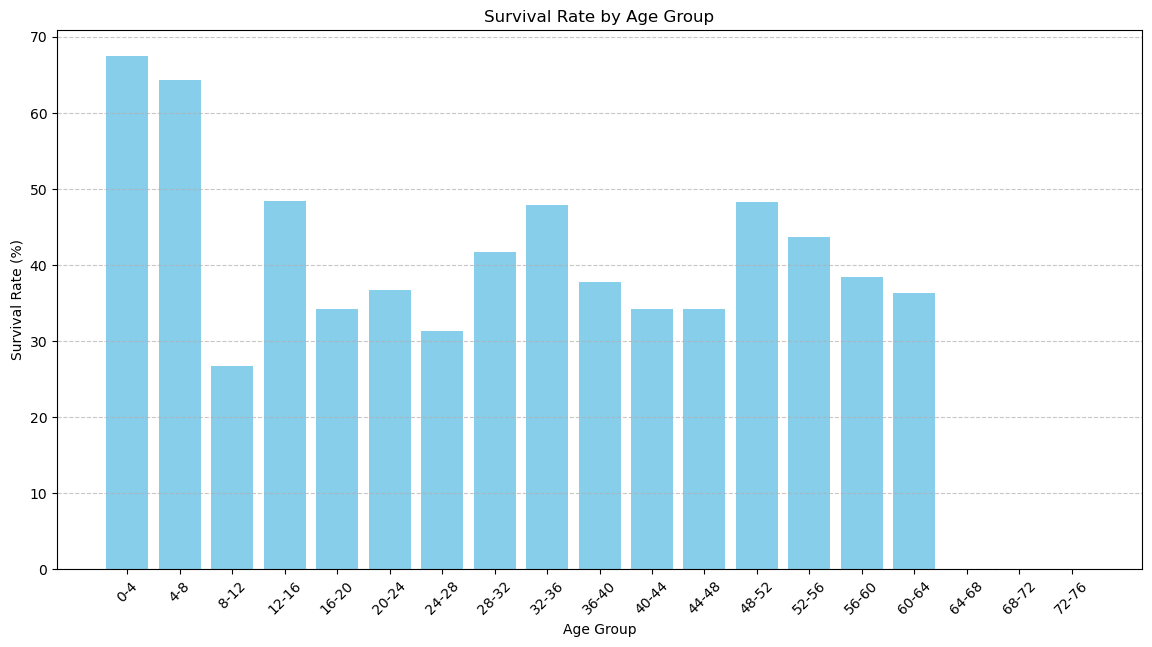

In [27]:
plt.figure(figsize=(14, 7))
plt.bar(age_grouped['AgeGroup'][:-1], age_grouped['SurvivalRate'][:-1] * 100, color='skyblue')  # Multiplied by 100 for percentage
plt.xlabel('Age Group')
plt.ylabel('Survival Rate (%)')
plt.title('Survival Rate by Age Group')
plt.xticks(rotation=45)  # Rotate the age group labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("figures/survival_rate_by_age_group.png")
plt.show()

It is really hard to observe any trend appart from the younger group. There is a big probability to survive for all the children younger than 8 years.

As a last attempt to find another trend we will plot a confusion matrix.

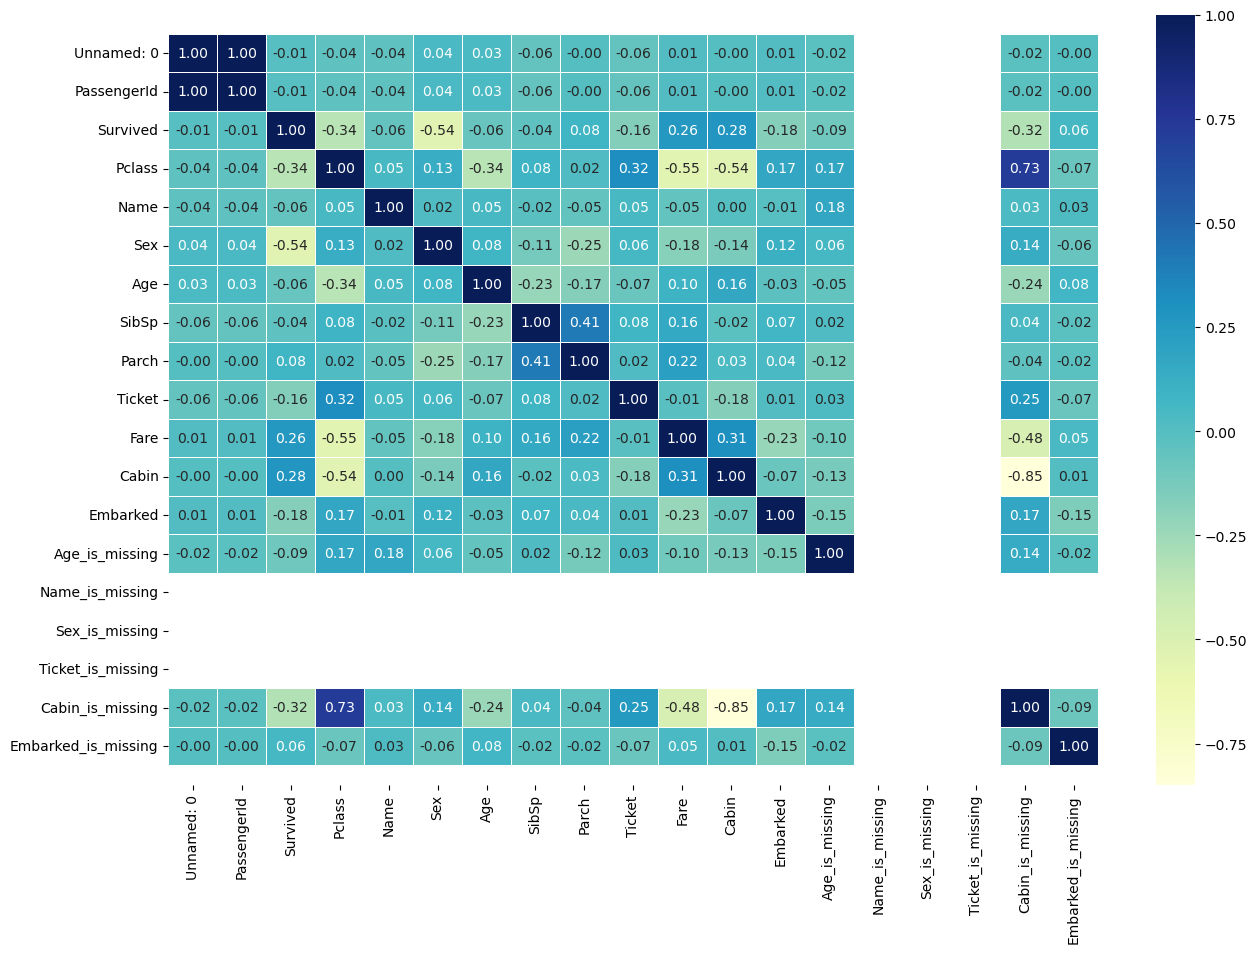

In [28]:
# Let's make a correlation matrix
corr_matrix = df_processed.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 annot_kws={"size" : 10},
                 linewidth=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");
bottom, top =ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

Apparently other two parameters that influence the results of survived are `Fare` and `Cabin` but obviously they are also dependant on `PClass` since a higher class results in a more expensive tickets and most probably the cabins were also grouped by classes.

Now we're ready to train our model

In [30]:
from sklearn.model_selection import train_test_split

# Setup a random seed
np.random.seed(698208)

# Get the data
X = df_processed.drop("Survived", axis=1)
y = df_processed["Survived"]

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [32]:
# Create a dictionary with all the estimators we want to check on to find the best model

models = {"LogisticRegression": LogisticRegression(),
          "SVC": SVC(),
          "LinearSVC": LinearSVC(),
          "RandomForestClassifier": RandomForestClassifier(),
          "GradientBoostingClassifier": GradientBoostingClassifier()}

# Create a function that from the dictionary models, trains each model and score them for further comparation

def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    '''
    # Set random seed
    np.random.seed(698208)
    # Make a dictionary to keep model scores
    model_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        print(f"Fitting {name}...")
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        print(f"Evaluating {name}...")
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [33]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

Fitting LogisticRegression...
Evaluating LogisticRegression...
Fitting SVC...
Evaluating SVC...
Fitting LinearSVC...
Evaluating LinearSVC...
Fitting RandomForestClassifier...


C:\Users\Asus\anaconda3\envs\titanic_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\titanic_env\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Asus\anaconda3\envs\titanic_env\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluating RandomForestClassifier...
Fitting GradientBoostingClassifier...
Evaluating GradientBoostingClassifier...


{'LogisticRegression': 0.7262569832402235,
 'SVC': 0.7150837988826816,
 'LinearSVC': 0.6815642458100558,
 'RandomForestClassifier': 0.8156424581005587,
 'GradientBoostingClassifier': 0.7877094972067039}

Now we can compare all the models graphically

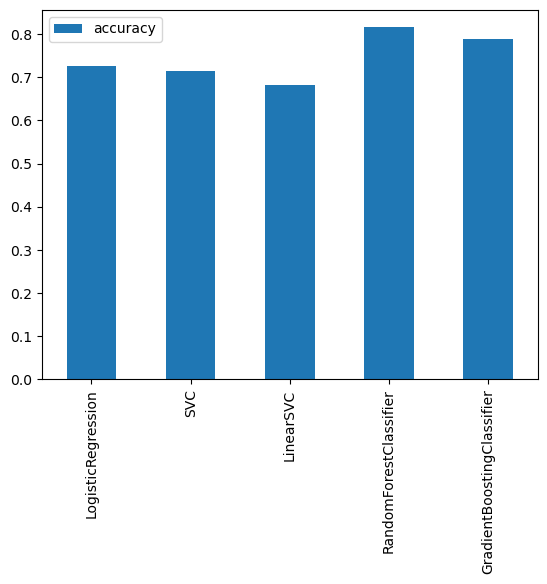

In [34]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

# As seen RandomForestClassifier and GradientBoostingClasifier are outperforming the other models, so we can discard the others and focus on the last two

Now it's time to improve the performance of the chosen estimators by tuning the hyperparameters. Firstly it can be made manually.

In [81]:
# Set a random seed
np.random.seed(698208)

# Tune RandomForestClassifier

train_scores = []
test_scores = []

# Create a different list of values for the n_estimators

n_estimators = np.arange(40, 61, 1)

# Setup the instance

rfc = RandomForestClassifier()

# Loop through the different values
for i in n_estimators:
    # Set the parameters
    rfc.set_params(n_estimators=i)

    # Fit each model
    rfc.fit(X_train, y_train)

    # Update the train score list
    train_scores.append(rfc.score(X_train, y_train))

    # Update the test score list
    test_scores.append(rfc.score(X_test, y_test))

Maximum RFC score on the test data: 84.36% for 52 estimators


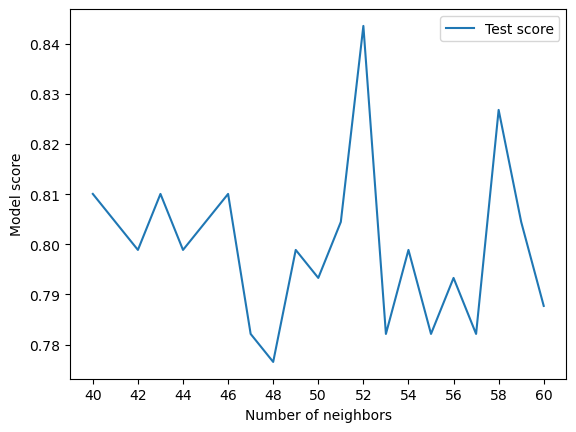

In [83]:
# plt.plot(n_estimators, train_scores, label="Train score")
plt.plot(n_estimators, test_scores, label="Test score")
plt.xticks(np.arange(40, 62, 2))
plt.xlabel("Number of estimators")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum RFC score on the test data: {max(test_scores)*100:.2f}% for {n_estimators[np.argmax(test_scores)]} estimators")

Now we repeat the same with the same parameter for the `GradientBoostingClassifier`

In [90]:
# Set a random seed
np.random.seed(698208)

# Tune GradientBoostingClassifier

train_scores = []
test_scores = []

# Create a different list of values for the n_estimators

n_estimators = np.arange(400, 610, 10)

# Setup the instance

gbc = GradientBoostingClassifier()

# Loop through the different values
for i in n_estimators:
    # Set the parameters
    gbc.set_params(n_estimators=i)

    # Fit each model
    gbc.fit(X_train, y_train)

    # Update the train score list
    train_scores.append(gbc.score(X_train, y_train))

    # Update the test score list
    test_scores.append(gbc.score(X_test, y_test))

Maximum GBC score on the test data: 83.24% for 500 estimators


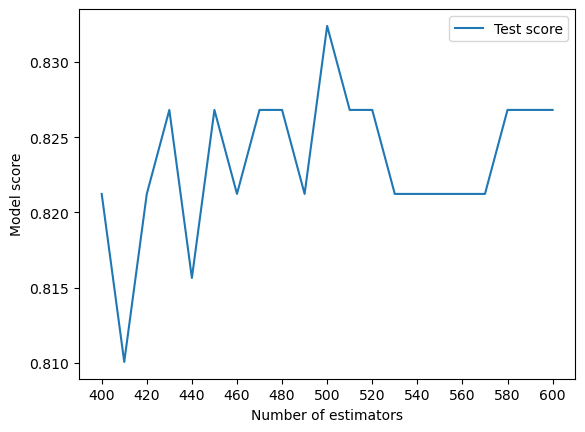

In [93]:
# plt.plot(n_estimators, train_scores, label="Train score")
plt.plot(n_estimators, test_scores, label="Test score")
plt.xticks(np.arange(400, 620, 20))
plt.xlabel("Number of estimators")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum GBC score on the test data: {max(test_scores)*100:.2f}% for {n_estimators[np.argmax(test_scores)]} estimators")

What if we do the same but with the learning rate?

In [110]:
# Set a random seed
np.random.seed(698208)

# Tune GradientBoostingClassifier

train_scores = []
test_scores = []

# Create a different list of values for the n_estimators

learning_rate = np.arange(0.1, 1.1, 0.1)

# Setup the instance

gbc = GradientBoostingClassifier()

# Loop through the different values
for i in learning_rate:
    # Set the parameters
    gbc.set_params(learning_rate=i)

    # Fit each model
    gbc.fit(X_train, y_train)

    # Update the train score list
    train_scores.append(gbc.score(X_train, y_train))

    # Update the test score list
    test_scores.append(gbc.score(X_test, y_test))

Maximum GBC score on the test data: 81.01% for a 0.6 learning rate


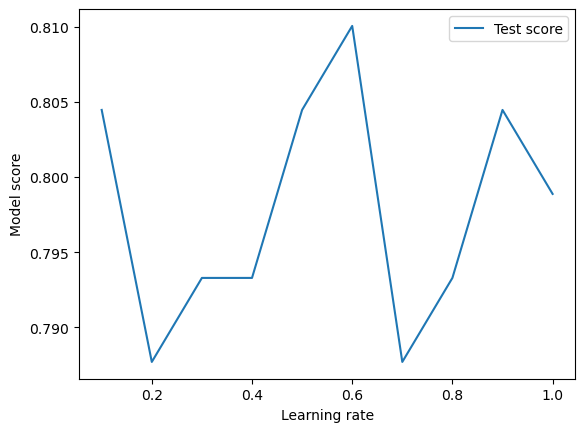

In [111]:
# plt.plot(n_estimators, train_scores, label="Train score")
plt.plot(learning_rate, test_scores, label="Test score")
# plt.xticks(np.arange(400, 620, 20))
plt.xlabel("Learning rate")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum GBC score on the test data: {max(test_scores)*100:.2f}% for a {learning_rate[np.argmax(test_scores)]} learning rate")

So the best values for the GBC estimator for learning rate lie between 0.4 and 0.6

## `RandomizedSearchCV` hyperparameter tuning

Now that we know ideal values for some parameters of the models, we can find a range for the other params by doing some random tuning

In [121]:
# First it is necessary to create the grids that will contain the random params
gbc_grid = {"n_estimators" : [10, 20, 50, 100, 200, 500, 1000],
            "learning_rate" : np.arange(0.4, 0.71, 0.01),
            "loss" : ["log_loss", "exponential"],
            "criterion" : ['friedman_mse', 'squared_error'],
            "min_weight_fraction_leaf" : np.arange(0.0, 0.6, 0.1),
            "max_depth" : np.arange(3, 11, 1),
            "subsample" : np.arange(0.7,1,0.1),
            "min_samples_leaf" : [1, 2, 5, 10],
            "min_samples_split" : [2, 5, 10, 20],
            "max_features" : ["log2", "sqrt", None]}

In [122]:
# Tune LogisticRegression

np.random.seed(698208)

# Setup random hyperparameter search for LogisticRegression
gbc_reg = RandomizedSearchCV(GradientBoostingClassifier(),
                             param_distributions=gbc_grid,
                             n_iter=50,
                             verbose=2)

# Fit random hyperparameter search model for LogisticRegression
gbc_reg.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=squared_error, learning_rate=0.5200000000000001, loss=log_loss, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=20, min_weight_fraction_leaf=0.1, n_estimators=10, subsample=0.7999999999999999; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.5200000000000001, loss=log_loss, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=20, min_weight_fraction_leaf=0.1, n_estimators=10, subsample=0.7999999999999999; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.5200000000000001, loss=log_loss, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=20, min_weight_fraction_leaf=0.1, n_estimators=10, subsample=0.7999999999999999; total time=   0.0s
[CV] END criterion=squared_error, learning_rate=0.5200000000000001, loss=log_loss, max_depth=9, max_features=log2, min_samples_leaf=5, min_samples_split=20, min_weight_fraction_le

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=50,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61,
       0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ]),
                                        'loss': ['log_loss', 'exponential'],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'min_weight_fraction_leaf': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'n_estimators': [10, 20, 50, 100, 200,
                                                         500, 1000],
                                        'subsample': array([0.7, 0.8, 0.9, 1. ])},
                   verbose=2)

In [123]:
gbc_reg.best_params_

{'subsample': 0.8999999999999999,
 'n_estimators': 500,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'loss': 'log_loss',
 'learning_rate': 0.45000000000000007,
 'criterion': 'squared_error'}

In [124]:
gbc_reg.score(X_test, y_test)

0.8156424581005587

In [125]:
# We can repeat the same process for the RandomForestClassifier

rfc_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [126]:
# Setup random hyperparameter search for LogisticRegression
rfc_reg = RandomizedSearchCV(RandomForestClassifier(),
                             param_distributions=rfc_grid,
                             n_iter=50,
                             verbose=2)

# Fit random hyperparameter search model for LogisticRegression
rfc_reg.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; 

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   verbose=2)

In [127]:
rfc_reg.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [128]:
rfc_reg.score(X_test, y_test)

0.8212290502793296

I decided to keep testing on the RandomForestClassifier to find the best hyperparameters, due to its better performance. Now the `GridSearchCV` function should be used to find the best parameters for this model

In [135]:
# Create the parameter grid with a total of 20 different parameters

search_grid = {'bootstrap' : [False],
               'max_features' : ['sqrt'],
               'n_estimators' : np.arange(100, 1000, 200),
               'max_depth' : [30, 50, 100],
               'min_samples_split' : [10],
               'min_samples_leaf' : [1]}

# Setup the grid search model
rfc_reg = GridSearchCV(RandomForestClassifier(),
                       param_grid=search_grid,
                       cv=5,
                       verbose=2)

# Fit the hyperparameter search model
rfc_reg.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimato

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'max_depth': [30, 50, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [10],
                         'n_estimators': array([100, 300, 500, 700, 900])},
             verbose=2)

In [133]:
rfc_reg.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 46}

In [134]:
rfc_reg.score(X_test, y_test)

0.8156424581005587